In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import utils

In [21]:
with open('experimental/cfg.pickle', 'rb') as f:
    cfg = pickle.load(f)
    
with open('experimental/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
with open('experimental/perspective_mtx.pickle', 'rb') as f:
    perspective_mtx = pickle.load(f)

In [22]:
test_images_path = glob.glob('./test_images/*_dst.jpg')
test_images_path

['./test_images/straight_lines1_dst.jpg',
 './test_images/test2_dst.jpg',
 './test_images/test6_dst.jpg',
 './test_images/test3_dst.jpg',
 './test_images/test1_dst.jpg',
 './test_images/test4_dst.jpg',
 './test_images/straight_lines2_dst.jpg',
 './test_images/test5_dst.jpg']

In [23]:
img = cv2.imread(test_images_path[0])
im_size = img.shape[::-1][1:]

binary = utils.get_binary_mask_from_image(img, cfg)

In [24]:
M = perspective_mtx['M']
MInv = perspective_mtx['MInv']

In [25]:
binary_warped = cv2.warpPerspective(binary, M, im_size)

In [26]:
leftx_base, rightx_base = utils.get_leftx_rightx_base(binary_warped)
leftx_base, rightx_base

(184, 998)

In [27]:
leftx, lefty, rightx, righty = utils.get_left_right_lane_xy(binary_warped, 
                                                            leftx_base, 
                                                            rightx_base)

In [28]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [29]:
left_fit, right_fit = get_lane_line_coefficients(leftx, lefty, rightx, righty)

In [30]:
left_fitx, right_fitx, ploty = get_lane_line_position(im_size[1], left_fit, right_fit)

In [31]:
lane_pts = utils.get_lane_pts_for_fillPoly(left_fitx, right_fitx, ploty)

In [32]:
img_lane_warped = utils.get_lane_rectangle_image(binary_warped, lane_pts)

In [33]:
img_lane = cv2.warpPerspective(img_lane_warped, MInv, im_size)

In [34]:
out_img = utils.weighted_img(img_lane, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

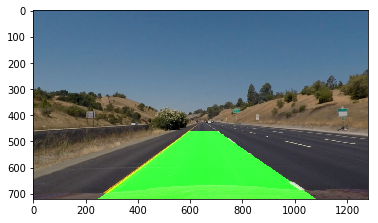

In [35]:
plt.imshow(out_img)

In [36]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [37]:
# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of R_curve (radius of curvature)
left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


In [38]:
left_curverad, right_curverad

(7986.7887317263821, 8885.7963320984254)

In [39]:
def get_lane_curvature(left_fit, right_fit, ploty):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad

In [40]:
def print_curvature_info(img, left_curvature, right_curvature):
    
    left_curve_text  = f'Left Curvature: {left_curvature:.2f} m'
    right_curve_text = f'Right Curvature: {right_curvature:.2f} m'
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    out_img = img.copy()
    out_img = cv2.putText(out_img, left_curve_text, (10, 50),
                          font, 2, (0, 0, 0), 5, cv2.LINE_AA)
    out_img = cv2.putText(out_img, right_curve_text, (10, 110),
                          font, 2, (0, 0, 0), 5, cv2.LINE_AA)
    
    return out_img

In [41]:
left_curvature, right_curvature = get_lane_curvature(left_fit, right_fit, ploty)

In [44]:
window_img = print_curvature_info(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                                  left_curvature, right_curvature)

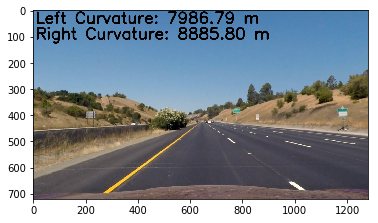

In [45]:
plt.imshow(window_img)

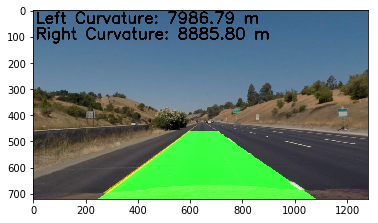

In [47]:
plt.imshow(print_curvature_info(out_img, left_curvature, right_curvature))
plt.savefig('output_images/lane_line_final_image.png')